In [4]:
!pip install -q requests pandas trafilatura cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.8 MB/s eta 0:00:00


In [6]:
# ==========================================
# Adzuna Job Fetcher + Cloudscraper (Anti-403)
# ==========================================

import os
import requests
import pandas as pd
import time
import trafilatura
import cloudscraper
import re
from datetime import datetime, timedelta
from pathlib import Path
from google.colab import userdata

# -------------------------
# Load environment variables
# -------------------------
try:
    APP_ID = userdata.get('ADZUNA_APP_ID')
    APP_KEY = userdata.get('ADZUNA_APP_KEY')
except:
    APP_ID = None
    APP_KEY = None

if not APP_ID or not APP_KEY:
    raise ValueError("❌ Missing Adzuna API credentials. 請檢查 Colab 左側『鑰匙』圖示內的名稱是否正確。")

# -------------------------
# Config
# -------------------------
COUNTRY = "us"
CITY = "Baltimore"
KEYWORDS = ["data scientist", "data analyst"]
RESULTS_PER_PAGE = 50
MAX_PAGES = 5
DAYS_BACK = 60
BASE_URL = f"https://api.adzuna.com/v1/api/jobs/{COUNTRY}/search"

# 🎯 Title Filtering Rules
TARGET_TITLE_KEYWORDS = ["data scientist", "senior data scientist", "sr. data scientist", "lead data scientist", "principal data scientist", "staff data scientist", "data analyst", "senior data analyst"]
EXCLUDED_TITLE_KEYWORDS = ["architect", "engineer", "manager", "consultant", "director", "vp", "vice president", "head of", "marketing", "sales", "product"]

# 初始化破解器
scraper = cloudscraper.create_scraper(browser={'browser': 'chrome', 'platform': 'windows', 'mobile': False})

def is_relevant_title(title: str) -> bool:
    if not title: return False
    title_lower = title.lower()
    has_target = any(k in title_lower for k in TARGET_TITLE_KEYWORDS)
    has_excluded = any(k in title_lower for k in EXCLUDED_TITLE_KEYWORDS)
    return has_target and not has_excluded

def quick_skill_scan(text):
    """簡單掃描文字中包含的技能關鍵字"""
    if not text: return ""
    skills = ['Python', 'SQL', ' R ', 'SAS', 'Stata', 'Machine Learning', 'Causal Inference', 'PhD', 'Epidemiology', 'Tableau', 'Power BI']
    found = [s.strip() for s in skills if re.search(r'\b' + re.escape(s.strip()) + r'\b', text, re.I)]
    return ", ".join(list(set(found)))

# -------------------------
# 🌐 強效版 Web Scraping Logic (對抗高級防護)
# -------------------------
def fetch_full_description(url):
    """
    使用進階 cloudscraper 設置繞過更嚴格的 403 封鎖
    """
    # 建立多種可能的 User-Agent 輪替
    scraper = cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'desktop': True
        }
    )

    try:
        # 增加一次重試機會
        for _ in range(2):
            response = scraper.get(url, timeout=20)

            if response.status_code == 200:
                # 使用 trafilatura 提取，並加入過濾短內容的邏輯
                content = trafilatura.extract(response.text, include_tables=True)
                if content and len(content) > 300:
                    return content.strip()

            # 如果失敗，稍微停頓換個姿勢重試
            time.sleep(2)

    except Exception as e:
        pass
    return None

# -------------------------
# Fetch Jobs
# -------------------------
all_jobs = []
cutoff_date = datetime.now() - timedelta(days=DAYS_BACK)

for keyword in KEYWORDS:
    for page in range(1, MAX_PAGES + 1):
        params = {
            "app_id": APP_ID,
            "app_key": APP_KEY,
            "what": keyword,
            "where": CITY,
            "results_per_page": RESULTS_PER_PAGE,
            "sort_by": "date",
        }

        print(f"📥 Fetching '{keyword}' | page {page}")
        response = requests.get(f"{BASE_URL}/{page}", params=params)
        response.raise_for_status()

        data = response.json()
        results = data.get("results", [])
        if not results: break

        for job in results:
            created = job.get("created")
            created_dt = datetime.fromisoformat(created.replace("Z", ""))
            if created_dt < cutoff_date: continue

            title = job.get("title")
            if not is_relevant_title(title): continue

            # --- 開始抓取完整描述 ---
            redirect_url = job.get("redirect_url")
            print(f"   🔍 Anti-403 Scraping for: {title[:35]}...")

            full_desc = fetch_full_description(redirect_url)

            # 判斷狀態
            status = "Success" if full_desc else "Failed/Snippet"
            final_description = full_desc if full_desc else job.get("description")

            all_jobs.append({
                "title": title,
                "company": job.get("company", {}).get("display_name"),
                "location": job.get("location", {}).get("display_name"),
                "created": created,
                "description": final_description,
                "full_text_status": status,
                "detected_skills": quick_skill_scan(final_description),
                "redirect_url": redirect_url,
                "keyword": keyword,
            })

            # 💡 禮貌爬蟲：長網址處理需要時間，建議間隔 1.5 秒
            time.sleep(1.5)

print("\n✅ Fetch and Scraping completed")
print(f"🔢 Total jobs collected: {len(all_jobs)}")

# -------------------------
# Save to CSV
# -------------------------
output_path = Path("jobs_final_fixed_v2.csv")
df = pd.DataFrame(all_jobs)
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"💾 Saved to {output_path.resolve()}")
df[['title', 'full_text_status', 'detected_skills']].head()

📥 Fetching 'data scientist' | page 1
   🔍 Anti-403 Scraping for: Data Scientist - Cost of Care Repor...
   🔍 Anti-403 Scraping for: Data Scientist- Value-Based Care Re...
   🔍 Anti-403 Scraping for: Data Scientist Fellow, Baseball Ana...
   🔍 Anti-403 Scraping for: AI & GenAI Data Scientist-Senior As...
   🔍 Anti-403 Scraping for: Data Scientist (Oncology) - Staff...
   🔍 Anti-403 Scraping for: Data Scientist...
   🔍 Anti-403 Scraping for: Data Scientist with Security Cleara...
   🔍 Anti-403 Scraping for: Data Scientist Fellow...
   🔍 Anti-403 Scraping for: Principal Data Scientist...
   🔍 Anti-403 Scraping for: Sr Principal Data Scientist...
   🔍 Anti-403 Scraping for: Senior Data Scientist...
   🔍 Anti-403 Scraping for: Sr Principal Data Scientist with Se...
   🔍 Anti-403 Scraping for: Sr Principal Data Scientist...
📥 Fetching 'data scientist' | page 2
   🔍 Anti-403 Scraping for: Data Scientist, Senior with Securit...
   🔍 Anti-403 Scraping for: Data Scientist, Senior with Securit...

,title,full_text_status,detected_skills
0,Data Scientist - Cost of Care Reporting (Hybrid),Success,Machine Learning
1,Data Scientist- Value-Based Care Reporting (Hy...,Success,Machine Learning
2,"Data Scientist Fellow, Baseball Analytics",Success,"R, SQL, Python"
3,AI & GenAI Data Scientist-Senior Associate,Success,"Machine Learning, SQL, Python"
4,Data Scientist (Oncology) - Staff,Success,Machine Learning


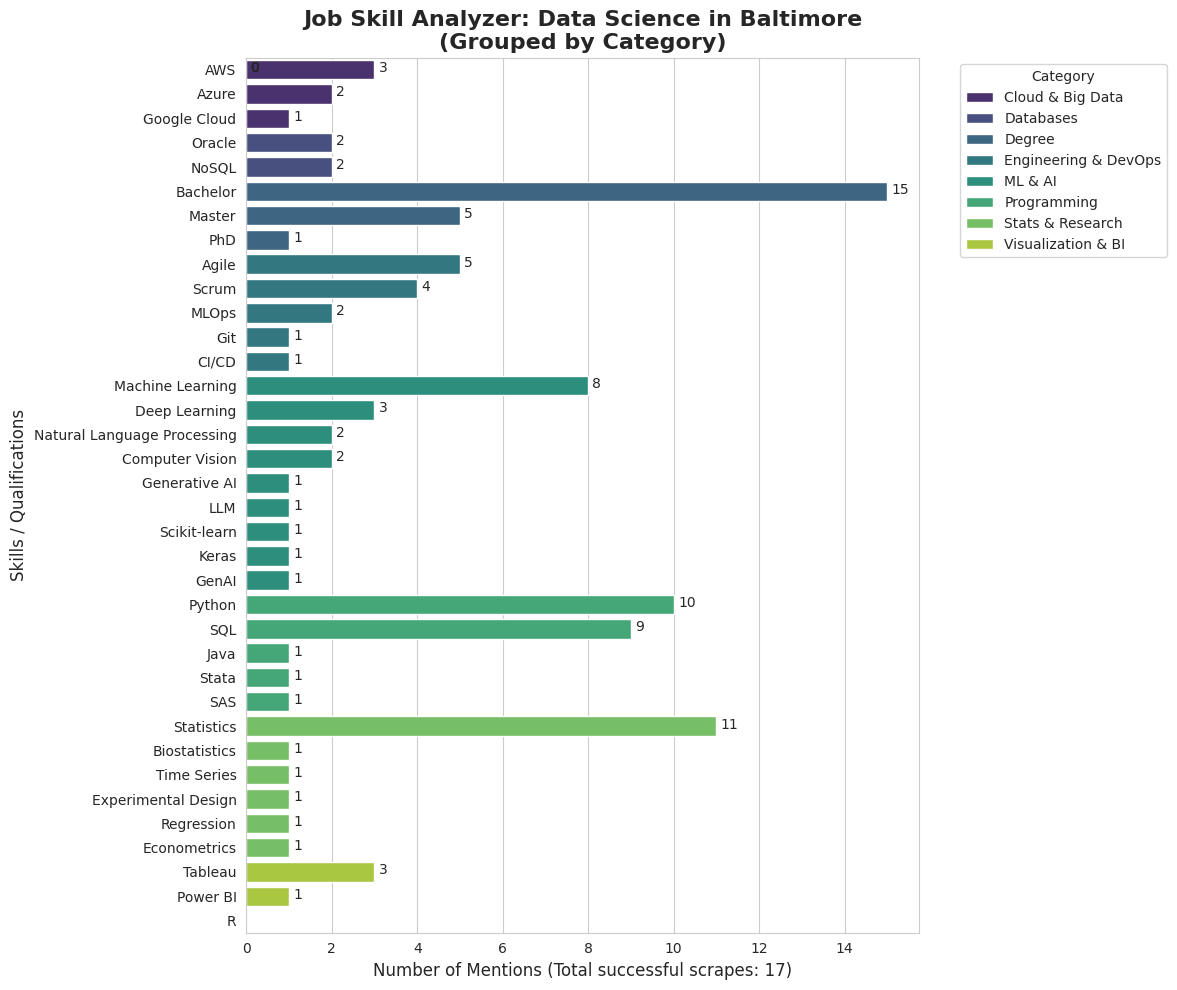

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns # 建議加裝 seaborn 讓顏色更漂亮

# 1. 讀取最新的結果
df = pd.read_csv('jobs_final_fixed_v2.csv')
df_success = df[df['full_text_status'].str.contains('Success')].copy()

# 2. 定義針對你背景的關鍵字清單
skill_keywords = {
    # 程式語言 (基礎)
    'Programming': [
        'Python', 'SQL', ' R ', 'SAS', 'Stata', 'Julia', 'C++', 'Java', 'Scala', 'Go', 'Bash', 'Shell'
    ],

    # 雲端與大數據 (科技業核心)
    'Cloud & Big Data': [
        'AWS', 'Azure', 'GCP', 'Google Cloud', 'Snowflake', 'Databricks', 'Spark', 'Hadoop',
        'Kafka', 'Redshift', 'BigQuery', 'Athena', 'Glue', 'Terraform', 'Airflow'
    ],

    # 資料庫技術
    'Databases': [
        'PostgreSQL', 'MySQL', 'MongoDB', 'NoSQL', 'SQL Server', 'Oracle', 'Cassandra'
    ],

    # 機器學習與人工智慧 (最新技術)
    'ML & AI': [
        'Machine Learning', 'Deep Learning', 'Reinforcement Learning', 'NLP', 'Natural Language Processing',
        'Computer Vision', 'Generative AI', 'GenAI', 'LLM', 'GPT', 'Scikit-learn', 'TensorFlow',
        'PyTorch', 'Keras', 'XGBoost', 'LightGBM', 'CatBoost'
    ],

    # 統計、因果推斷與流行病學 (你的專業優勢)
    'Stats & Research': [
        'Statistics', 'Biostatistics', 'Causal Inference', 'Epidemiology', 'Econometrics', 'Bayesian',
        'Survival Analysis', 'Longitudinal', 'Time Series', 'A/B Testing', 'Experimental Design',
        'Propensity Score', 'Clinical Trials', 'Regression', 'Hypothesis Testing', 'RCT'
    ],

    # 資料視覺化與商業智慧
    'Visualization & BI': [
        'Tableau', 'Power BI', 'Looker', 'Qlik', 'Matplotlib', 'Seaborn', 'Plotly', 'Shiny', 'D3.js'
    ],

    # 工程開發與工作流
    'Engineering & DevOps': [
        'Git', 'GitHub', 'CI/CD', 'Docker', 'Kubernetes', 'MLOps', 'Agile', 'Scrum', 'DevOps'
    ],

    # 學歷門檻
    'Degree': [
        'PhD', 'Ph.D.', 'Doctorate', 'Master', 'M.S.', 'MSc', 'MPH', 'MBA', 'Bachelor'
    ]
}

# 建立反向查詢表 (用來將技能對應回類別以便著色)
skill_to_cat = {k: cat for cat, ks in skill_keywords.items() for k in ks}

def find_skills_optimized(text):
    if pd.isna(text): return []
    res = []
    text_lower = text.lower()
    for cat, kws in skill_keywords.items():
        for k in kws:
            # 特殊處理 R 以免匹配到單字中間
            pattern = r'\b' + re.escape(k.strip()) + r'\b'
            if re.search(pattern, text, re.I):
                # 同義詞歸一化 (例如 Ph.D. -> PhD)
                val = k.strip()
                if val == 'Ph.D.': val = 'PhD'
                if val == 'M.S.': val = 'Master'
                res.append(val)
    return list(set(res))

# 3. 分析數據
df_success['found_skills'] = df_success['description'].apply(find_skills_optimized)
all_found = [item for sublist in df_success['found_skills'] for item in sublist]
skill_counts = pd.Series(all_found).value_counts().reset_index()
skill_counts.columns = ['Skill', 'Count']

# 映射類別並排序
skill_counts['Category'] = skill_counts['Skill'].map(skill_to_cat)
skill_counts = skill_counts.sort_values(['Category', 'Count'], ascending=[True, False])

# 4. 繪圖優化
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid") # 使用格線背景

# 使用 Category 來著色
ax = sns.barplot(
    data=skill_counts,
    y='Skill',
    x='Count',
    hue='Category',
    dodge=False,
    palette='viridis'
)

# 加上數據標籤
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1, p.get_y() + p.get_height()/2 + 0.1, f'{int(width)}', ha="left")

plt.title('Job Skill Analyzer: Data Science in Baltimore\n(Grouped by Category)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Mentions (Total successful scrapes: {})'.format(len(df_success)), fontsize=12)
plt.ylabel('Skills / Qualifications', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

✅ Collected 50 Data Scientist jobs


,title,company,location,description,via,posted_at,job_link,fetched_at
0,"Data Scientist-Remote, DMV Area",IIIIIIUS,"Silver Spring, MD",Description\n\nICF is seeking mid-to-senior le...,ICF Career,20 hours ago,None,2026-01-15T20:19:40.733735
1,Data Scientist,Defense Counterintelligence and Security Agency,"Quantico, VA (+5 others)",DCSA's PEO (National Background Investigation ...,USAJobs,11 days ago,None,2026-01-15T20:19:40.733803
2,Data Scientist SME,Leidos,"Alexandria, VA",Description\n\nLeidos National Security Sector...,Leidos Careers,2 days ago,None,2026-01-15T20:19:40.733823
3,DATA SCIENTIST,AF Force Renewal,"Washington, DC (+44 others)",The PALACE Acquire Program offers you a perman...,Federal Internship Portal - USAJobs,None,None,2026-01-15T20:19:40.733838
4,Data Scientist 4,RealmOne,Maryland,Are you VIGILANT about your career? RealmOne d...,Indeed,2 days ago,None,2026-01-15T20:19:40.733851
